In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

lat_a=0.0871
lat_NL=64; lat_NT=96
lat_L=lat_a*lat_NL
hbarc = 1/197.327
lat_aInv=1/(lat_a*hbarc)

In [2]:
i_start=0; i_end=0+100
cfg2srcs={}
path='/capstor/store/cscs/userlab/lp139/lyan/code/glwc2/project2/03_NpiScatteringWilson/dataPrepare/MILC_a09m130W/data_aux/srcs.h5'
with h5py.File(path) as f:
    for cfg in f.keys():        
        cfg2srcs[cfg]=f[cfg][i_start:i_end]

from random import shuffle

path='/capstor/store/cscs/userlab/lp139/lyan/code/projectData/03_NpiScatteringWilson/MILC_a09m130W/data_post/'
cfgs=os.listdir(path)
cfgs.sort()
data=[]
for i,cfg in enumerate(cfgs):
    print(i,len(cfgs),end='            \r')
    file=f'{path}{cfg}/N.h5_0mom'
    with h5py.File(file) as f:
        # srcs=list(f['data'].keys())
        # shuffle(srcs)
        srcs=['sx{:02d}sy{:02d}sz{:02d}st{:02d}'.format(sx,sy,sz,st) for sx,sy,sz,st in cfg2srcs[cfg]]
        
        def get(src):
            t=f['data'][src]['N_a'][:,16,:]
            t_bw=np.roll(np.flip(t,axis=0),1,axis=0)
            return ( (t[:,0]+t[:,5]) - (t_bw[:,10]+t_bw[:,15]) )/4
        
        t=[get(src) for src in srcs]
        data.append(t)
    # break
data=np.array(data)
print(data.shape)

path='/capstor/store/cscs/userlab/lp139/lyan/code/projectData/03_NpiScatteringWilson/MILC_a09m130W/data_merge/Nsrc=.h5'
with h5py.File(path,'w') as f:
    f.create_dataset('srcs',data=np.array([cfg2srcs[cfg] for cfg in cfgs]))
    f.create_dataset('N',data=data)

(162, 100, 96)     


In [2]:
from random import shuffle

path='/capstor/store/cscs/userlab/lp139/lyan/code/projectData/03_NpiScatteringWilson/MILC_a09m130W/data_merge/Nsrc=100.h5'
with h5py.File(path) as f:
    data=f['N'][:]
    
    t=[]
    for dat in data:
        inds=list(range(len(dat)))
        # shuffle(inds)
        t.append(dat[inds])
    data=np.real(np.array(t))

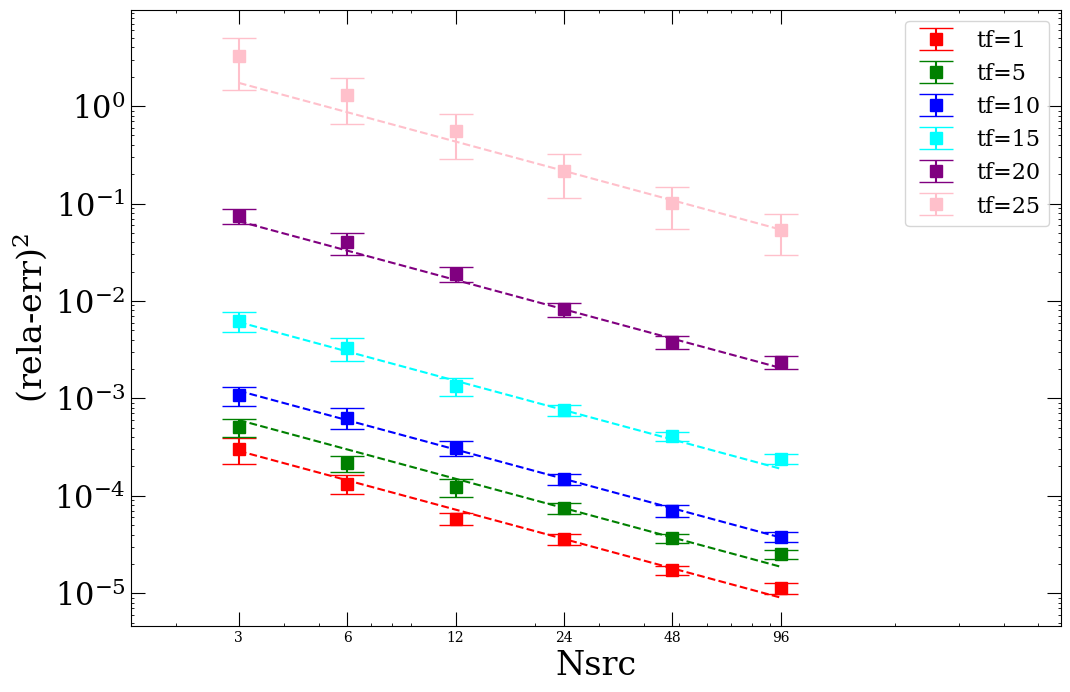

In [3]:
Nsrc_base=8*3
# Nsrcs=[1,2,4,8,16,32,64,125,250,500]
Nsrcs=np.array([1,2,4,8,16,32])*3
tfs=[1,4,7,9,11,13,15]
tfs=[1,5,10,15,20,25]

fig, axs = yu.getFigAxs(1,1,Lrow=8,Lcol=12)
ax=axs[0,0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([Nsrcs[0]/2,Nsrcs[-1]*6])
ax.set_xticks(Nsrcs)
ax.set_xticklabels([str(Nsrc) for Nsrc in Nsrcs],size=10)
ax.set_xlabel('Nsrc',size=24)
ax.set_ylabel(f'(rela-err)$^2$',size=24)

# plt_x=np.sqrt(Nsrcs); plt_y=np.sqrt(Nsrcs)/np.sqrt(Nsrc_base)
# ax.plot(plt_x,plt_y,color='black',ls='--',marker='')

colors=['r','g','b','cyan','purple','pink','orange']
for Nsrc in Nsrcs:
    def func(dat):
        N=len(dat)
        # t_base=np.sqrt(np.var(np.mean(dat[:,:Nsrc_base,:],axis=1),axis=0,ddof=1)/N)
        mean=np.mean(np.mean(dat,axis=1),axis=0)
        err=np.sqrt(np.var(np.mean(dat[:,:Nsrc,:],axis=1),axis=0,ddof=1)/N)    
        return err**2/mean**2
    mean,err,cov=yu.jackknife2(data,func)
    
    if Nsrc==Nsrc_base:
        for i,tf in enumerate(tfs):
            plt_x=Nsrcs; plt_y=Nsrc_base/np.array(Nsrcs)*mean[0][tf]
            ax.plot(plt_x,plt_y,color=colors[i],ls='--',marker='')

    for i,tf in enumerate(tfs):
        plt_x=Nsrc; plt_y=mean[0][tf]; plt_yerr=err[0][tf]
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i],label=f'tf={tf}' if Nsrc==Nsrc_base else None)

ax.legend(fontsize=16)
plt.savefig('fig/c2pt_nucleon_scaling.pdf')

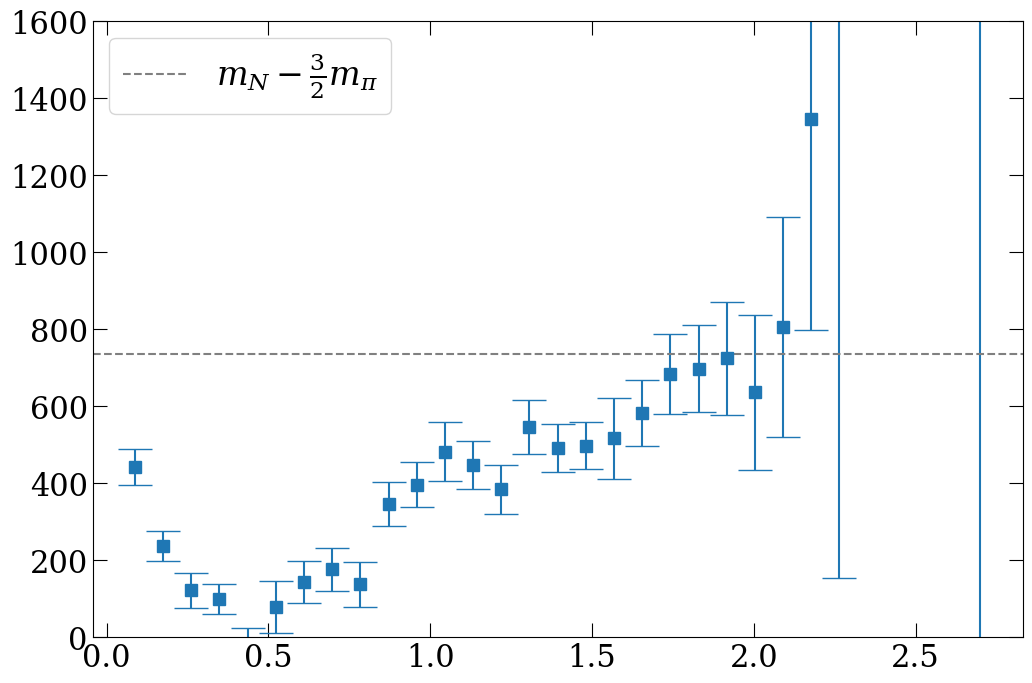

In [47]:
fig, axs = yu.getFigAxs(1,1,Lrow=8,Lcol=12)
ax=axs[0,0]
Nsrc=data.shape[1]
def func(dat):
    N=len(dat)
    # t_base=np.sqrt(np.var(np.mean(dat[:,:Nsrc_base,:],axis=1),axis=0,ddof=1)/N)
    mean=np.mean(np.mean(dat,axis=1),axis=0)
    err=np.sqrt(np.var(np.mean(dat[:,:Nsrc,:],axis=1),axis=0,ddof=1)/N) 
    SNR=mean/err # exp[-(mN-3mpi/2)t]  
    meff=np.log(SNR/np.roll(SNR,-1))
    return meff
xunit=lat_a
yunit=lat_aInv
mean,err,cov=yu.jackknife2(data,func)
ts=np.arange(1,32)

plt_x=ts*xunit; plt_y=mean[0][ts]*yunit; plt_yerr=err[0][ts]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr)
val=938-135*3/2
ax.axhline(val,ls='--',marker='',color='grey',label=r'$m_N-\frac{3}{2}m_\pi$')
ax.set_ylim([0,1600])
ax.legend()
None